In [12]:
import rosbag
import re

In [40]:
def TopicFilter(bag, BASE_ROBOT_ID):

    topics = bag.get_type_and_topic_info().topics.keys()
    topics_excluing_list = []
    topics_valid_list = []

    # remove topics that appeared in argos
    regex = re.compile('^/epuck+_.+_.+/')
    argos_sim_topics = filter(regex.search, topics)
        
    # count the number of robots present in the rosbag file
    regex = re.compile('^/epuck+_.+/init_merkle_tree')
    number_of_robots_in_bag = len(filter(regex.search, topics))
    
    for id in xrange(BASE_ROBOT_ID,BASE_ROBOT_ID + number_of_robots_in_bag):
        topic_goal = "/epuck_" + str(id) + "/diff_drive_go_to_goal" + "/goal"
        topic_goal_achieved = "/epuck_" + str(id) + "/diff_drive_go_to_goal" + "/goal_achieved"
        topic_distance_to_goal = "/epuck_" + str(id) + "/diff_drive_go_to_goal" + "/distance_to_goal"
        topic_goto = "/epuck_" + str(id) + "/diff_drive_go_to_goal" + "/go_to"
        topic_results = "/epuck_" + str(id) + "/diff_drive_go_to_goal" + "/result"
        topic_cancel = "/epuck_" + str(id) + "/diff_drive_go_to_goal" + "/cancel"
        topic_status = "/epuck_" + str(id) + "/diff_drive_go_to_goal" + "/status"
        topic_cmd_vel = "/epuck_" + str(id) + "/cmd_vel"

        topics_excluing_list.extend([topic_goal, topic_distance_to_goal, topic_goto, 
                                     topic_goal_achieved, topic_results, topic_cancel, 
                                     topic_status, topic_cmd_vel])

    topics_excluing_list.extend(['/rosout', '/rosout_agg'])
    topics_excluing_list.extend(argos_sim_topics)

    for topic in topics:
        if topic not in topics_excluing_list:
            topics_valid_list.append(topic)
          
    return topics_valid_list

In [41]:
bag = rosbag.Bag('/home/eddie/experiments_results/real_robots/R24/data/2020-06-15-23-26-42.bag')
topics_valid_list = TopicFilter(bag, 20)

with rosbag.Bag('/home/eddie/output.bag', 'w') as outbag:
    for topic, msg, t in bag.read_messages(topics=topics_valid_list):
        outbag.write(topic, msg, t)

# Neighbor link analysis

In [6]:

# DF= DF.to_datetime(DF['t'], unit='ns')
# print(DF.head())

# def get_location(g):
#     g['topic'][:9].unique()

    

def MaxLinkLengthPerExperiment(df):
    test = []
    test1=[]
    test2=[]
    all_links = []
    mydict = {'/epuck_%d/' % jj:[] for jj in xrange(20,36)}

    by_second = df.groupby(by=[df.index.hour, df.index.minute, df.index.second])
  
    
#     robots_by_seconds = by_second.apply(lambda g:pd.Series([r[:9] for r in g['topic']].unique())
    for n, g in by_second:
        
        neighbors_df = g[map(lambda x: x[10:] == 'comm/neighbor_list', g['topic'].values)]
        positions = g[map(lambda x: x[10:] == 'position', g['topic'].values)]
        positions_dict = {r['topic'][:10] :(r['msg'].position.x, r['msg'].position.y) for i,r in positions.iterrows()}
       
        try:
            if positions.shape[0] >= neighbors_df.shape[0]: 

                pairs = [(positions_dict[r['topic'][:10]], [positions_dict['/epuck_%d/' % x.ID] for x in r['msg'].neighbors if (x.ID >= 20) and (x.ID < 35)]) for i,r in neighbors_df.iterrows()]
                pairs = [p for p in pairs if p[1]!=[]]

                for i,r in neighbors_df.iterrows():

                    mydict[r['topic'][:10]].append((positions_dict[r['topic'][:10]],[positions_dict['/epuck_%d/' % x.ID] for x in r['msg'].neighbors if (x.ID >= 20) and (x.ID < 35)]))

                for p in pairs:

                    dists = max([np.sqrt((p[0][0] - w[0])**2 + (p[0][1] - w[1])**2) for w in p[1]])
                    dists1 = np.mean([np.sqrt((p[0][0] - w[0])**2 + (p[0][1] - w[1])**2) for w in p[1]])
                    dists2 = min([np.sqrt((p[0][0] - w[0])**2 + (p[0][1] - w[1])**2) for w in p[1]])
                    dists_all = [np.sqrt((p[0][0] - w[0])**2 + (p[0][1] - w[1])**2) for w in p[1]]
                    test.append(dists)
                    test1.append(dists1)
                    test2.append(dists2)
                    all_links.append(dists_all)
                
        except:
            pass
        
    return test, test1,test2, all_links, mydict

# upper, av, lower, all_, mydict_ = MaxLinkLengthPerExperiment(DF)

In [135]:
tt = DF.groupby(by=[DF.index.hour, DF.index.minute, DF.index.second])
print(tt.get_group((22,12,00)))

                                                                       msg  \
t                                                                            
2020-05-20 22:12:00.004  header: \n  seq: 1461\n  stamp: \n    secs: 15...   
2020-05-20 22:12:00.007  header: \n  seq: 1459\n  stamp: \n    secs: 15...   
2020-05-20 22:12:00.010  position: \n  x: 2.23439981787\n  y: 2.1866356...   
2020-05-20 22:12:00.010  position: \n  x: 0.383816639547\n  y: 1.006599...   
2020-05-20 22:12:00.010  position: \n  x: 0.234194158865\n  y: 0.752013...   
2020-05-20 22:12:00.010  position: \n  x: 2.10257821113\n  y: 0.6445135...   
2020-05-20 22:12:00.010  position: \n  x: 1.56818594728\n  y: 2.1323191...   
2020-05-20 22:12:00.010  position: \n  x: 0.0856475269338\n  y: 2.05112...   
2020-05-20 22:12:00.011  header: \n  seq: 1440\n  stamp: \n    secs: 15...   
2020-05-20 22:12:00.011  header: \n  seq: 1440\n  stamp: \n    secs: 15...   
2020-05-20 22:12:00.011                                         

In [ ]:
def MaxLinkLengthPerExperiment(df):
    test = []
    test1=[]
    test2=[]

    by_second = df.groupby(by=[df.index.hour, df.index.minute, df.index.second])
#     robots_by_seconds = by_second.apply(lambda g:pd.Series([r[:9] for r in g['topic']].unique())
    for n, g in by_second:
        

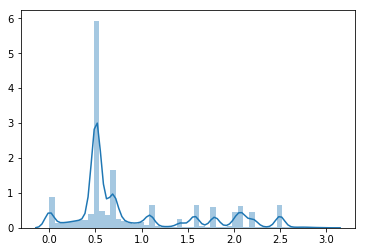

In [163]:
sns.distplot(upper)

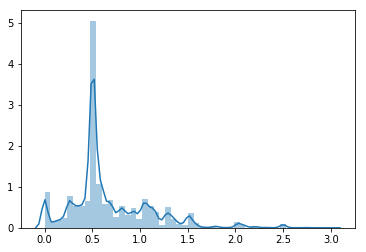

In [164]:
sns.distplot(av)

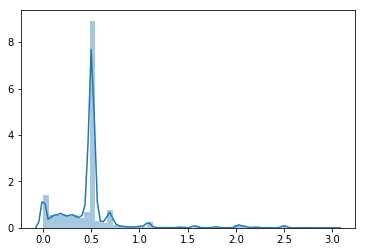

In [165]:
sns.distplot(lower)

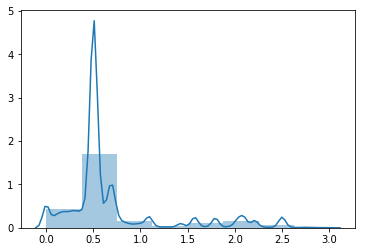

In [166]:
flat_all =  [item for sublist in all_ for item in sublist]
sns.distplot(flat_all, bins=8)

In [161]:
DF = ROSBagToPandasDataFrame('/Users/eddie/experiments_results/5x5-16-robots/data/2020-02-14-02-26-23.bag')
# # test_DF = DF.head(500)
test = [str(i)[:13] for i in DF['t']]

DF['t'] = pd.to_datetime(test, unit='ms')
DF=DF.set_index('t')

#test1=DF.groupby(by=[DF.index.hour, DF.index.minute, DF.index.second])


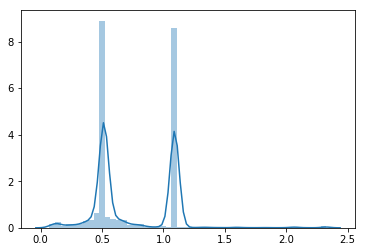

In [168]:
# mydict_2 = {k: [item for sublist in mydict_[k] for item in sublist] for k in mydict_}

links={'/epuck_%d/' % jj:[] for jj in xrange(20,36)}
for k in mydict_:
    for p in mydict_[k]:
        a=[np.sqrt((p[0][0] - w[0])**2 + (p[0][1] - w[1])**2) for w in p[1]]
        links[k].append(a)


links = {k:[item for sublist in links[k] for item in sublist] for k in links }
sns.distplot(links['/epuck_21/'])      

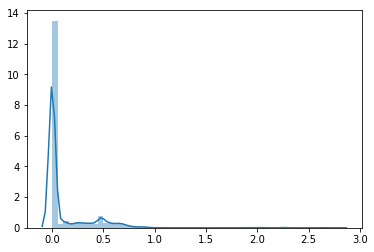

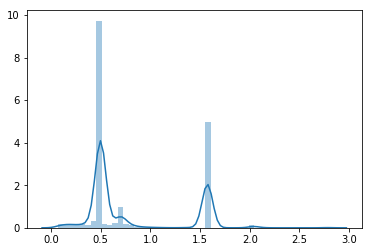

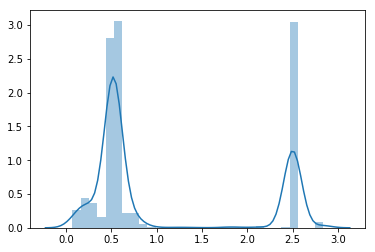

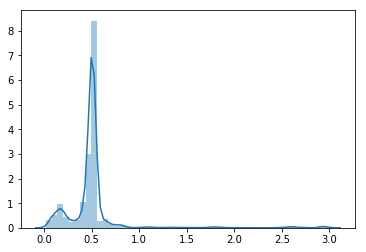

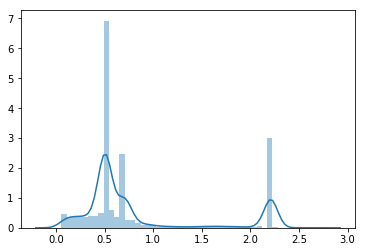

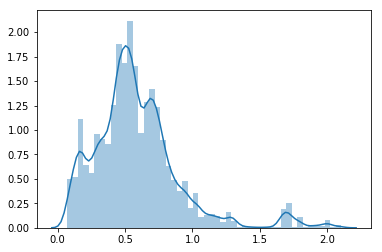

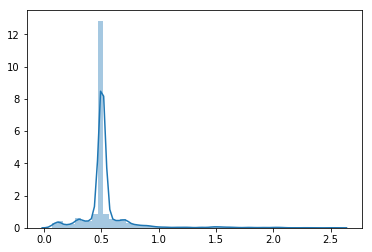

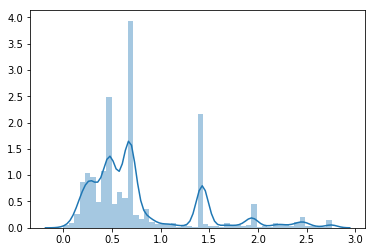

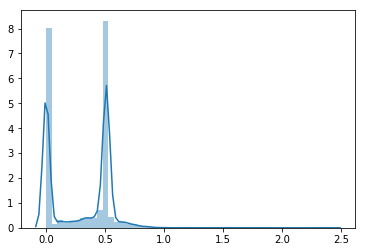

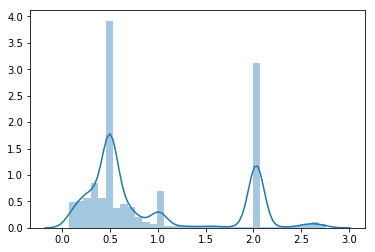

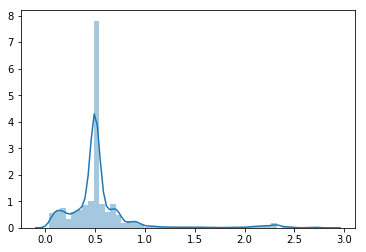

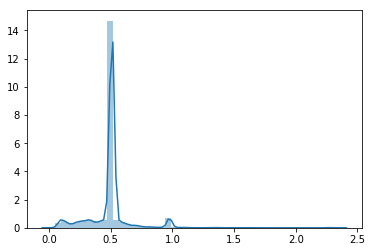

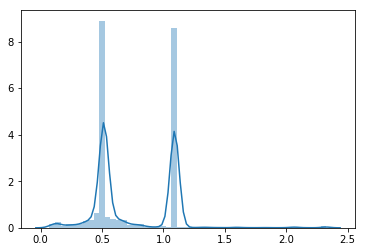

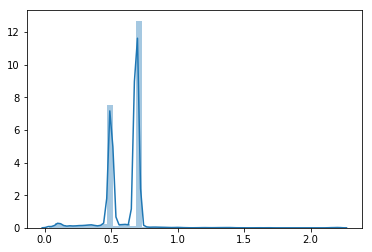

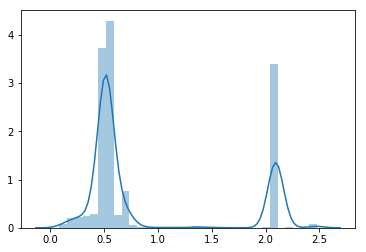

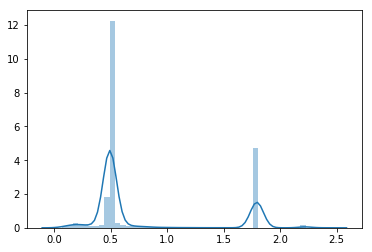

In [169]:
for k in links:
    fig,ax = plt.subplots()
    sns.distplot(links[k], ax=ax)
    

0.9238969627615409


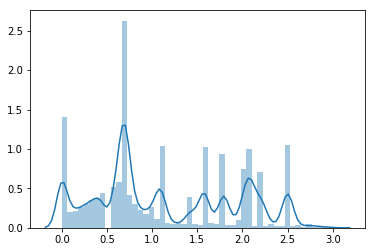

In [181]:
lala=pd.DataFrame(upper, columns=['upper'])
lala = lala[(lala['upper']>0.56)|(lala['upper']<0.46)]
print(np.median(lala))
sns.distplot(lala)

In [61]:
pd.to_datetime(str(1581643583123), unit='ms')

Timestamp('2020-02-14 01:26:23.123000')

In [13]:
from joblib import Parallel, delayed

def wrapper(_file):
    
    # Read Files
    DF = ROSBagToPandasDataFrame(_file)
    DF.to_csv(_file[:-4]+'.csv')
    
    # Make timestamp into seconds
    seconds = [str(i)[:13] for i in DF['t']]

    # make the index the timestamp
    DF['t'] = pd.to_datetime(seconds, unit='ms')
    DF      = DF.set_index('t')
    upper, av, lower, all_, mydict_ = MaxLinkLengthPerExperiment(DF)
    
    upper_df = pd.DataFrame(upper, columns=['max_length'])
    upper_df.to_csv(_file[:-4]+'_upper.csv', index=False)
    print(_file)
        
#     return upper

path = r'/Users/eddie/experiments_results/5x5-16-robots/data/'
ALL_FILES = glob2.glob(path + "*.bag")

# results = Parallel(n_jobs=4)(delayed(wrapper)(i) for i in ALL_FILES)

for ii in ALL_FILES:
    res=wrapper(ii)


# uppers_flat = [item for sublist in uppers for item in sublist]
# uppers_df   = pd.DataFrame(uppers_flat, columns=['upper'])
# uppers_df   = uppers_df[(uppers_df['upper']>0.56)|(uppers_df['upper']<0.46)]


# print('Median', np.median(uppers_df))
# print('Mean',   np.mean(uppers_df))
# sns.distplot(uppers_df)

/Users/eddie/experiments_results/5x5-16-robots/data/2020-03-21-17-38-08.bag
/Users/eddie/experiments_results/5x5-16-robots/data/2020-03-13-16-06-38.bag
/Users/eddie/experiments_results/5x5-16-robots/data/2020-03-12-03-18-13.bag
/Users/eddie/experiments_results/5x5-16-robots/data/2020-03-15-16-00-38.bag
/Users/eddie/experiments_results/5x5-16-robots/data/2020-03-21-19-03-32.bag
/Users/eddie/experiments_results/5x5-16-robots/data/2020-02-14-22-59-25.bag
/Users/eddie/experiments_results/5x5-16-robots/data/2020-04-23-15-07-21.bag
/Users/eddie/experiments_results/5x5-16-robots/data/2020-02-16-04-14-03.bag
/Users/eddie/experiments_results/5x5-16-robots/data/2020-02-14-02-26-23.bag
/Users/eddie/experiments_results/5x5-16-robots/data/2020-03-12-01-32-10.bag


(91358, 1)
max_length    1.097226
dtype: float64


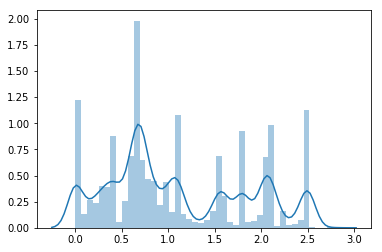

In [79]:
path = r'/Users/eddie/experiments_results/5x5-16-robots/data/'
ALL_FILES = glob2.glob(path + "*_upper.csv")

aux=[]
for csv_file in ALL_FILES:
    a=pd.read_csv(csv_file)
    a=a[a.index > 1000*10*16]
    a=a[a.index < ((a.shape[0]/10)/16 - 1000)*10*16]
    aux.append(a)

final = pd.concat(aux, axis=0)
print final.shape
final = final[(final['max_length']>0.55)|(final['max_length']<0.45)]
print(np.mean(final))
sns.distplot(final)

In [ ]:
def MaxLinkLenthOneRun(INITIAL_ID, NUMBER_OF_ROBOTS, THRESHOLD, DF):
    robots_neighbors_list = []

    for id in xrange(INITIAL_ID, INITIAL_ID+NUMBER_OF_ROBOTS):
        topic_name = '/epuck_' + str(id) + '/comm/neighbor_list'
        try:
            robots_neighbors_list = MaxLinkLengthPerRobot(DF, topic_name)
            robots_finishing_list.append(robots_neighbors_list)
        except:
            pass
           
    return max(robots_finishing_list)